# Data Science Workflow

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocess the Data

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    dummy_cols = ["Age_categories", "Fare_categories","Title", "Cabin_type","Sex"]
    for col in dummy_cols:
        df = create_dummies(df, col)
        
    return df

train = process(train)
holdout = process(holdout)

## Explore the Data

In [8]:
train[["SibSp","Parch","Survived"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


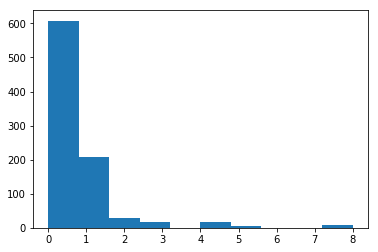

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train["SibSp"])
plt.show()

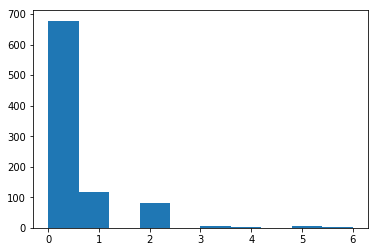

In [10]:
plt.hist(train["Parch"])
plt.show()

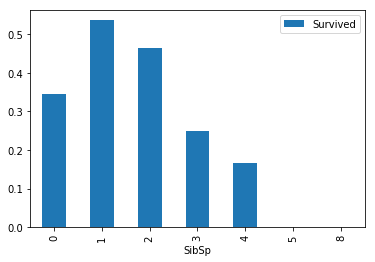

In [11]:
sib_pivot = pd.pivot_table(train, index="SibSp", values="Survived")
sib_pivot.plot.bar()
plt.show()

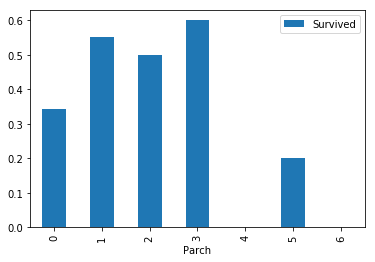

In [12]:
par_pivot = pd.pivot_table(train, index="Parch", values="Survived")
par_pivot.plot.bar()
plt.show()

Sum these two columns to explore the total number of family members each passenger had onboard.

## Engineer New Features

In [13]:
def is_alone(df):
    family_size = train["SibSp"] + train["Parch"]
    df["isalone"] = family_size.apply(lambda x: 1 if (x == 0) else 0)
    return df

train = is_alone(train)    
holdout = is_alone(holdout)

## Select the Best-Performing Features

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def select_features(df):
    df = df.select_dtypes(include=['int', 'float'])
    df = df.dropna(axis=1)
    
    all_X = df.drop(columns=['Survived','PassengerId'])
    all_y = df['Survived']
    
    rfc = RandomForestClassifier(n_estimators=10, random_state=1)
    selector = RFECV(rfc, cv=10)
    selector.fit(all_X, all_y)
    
    selected_cols = all_X.columns[selector.support_]
    print(selected_cols)
    
    return selected_cols

features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


## Select and Tune Different Algorithms

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        }
    ]
    
    for model in models:
        print(model["name"])
        grid = GridSearchCV(estimator=model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10,
                            iid=False)
        grid.fit(all_X, all_y)
        model["params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_estimator"] = grid.best_estimator_
        
        print(model["params"], " ", model["best_score"])
        
    return models

dict_of_models = select_model(train, features)

LogisticRegression


/Users/lucy/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


{'solver': 'liblinear'}   0.7017293723754399
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}   0.6983089320167972
RandomForestClassifier
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}   0.7409933605720123


## Make a Submission to Kaggle

In [17]:
def save_submission_file(model, features, filename='submit.csv'):
    predictions = model.predict(holdout[features])
    submission_df = {"PassengerId": holdout["PassengerId"],
                    "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index=False)
    
best_model = dict_of_models[2]["best_estimator"]

save_submission_file(best_model, features, filename='submit.csv')